# Bloch Simulation

References:
1. Lauzon - A Beginner's Guide to Bloch Equation Simulations of Magnetic Resonance Imaging Sequences. [[arXiv 2020]](https://arxiv.org/abs/2009.02789)
2. Nice animations: http://mriphysics.github.io/teaching-mri-intro.html

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Constants

GAMMA = 42576384.74  # Gyromagnetic ratio of 1H in H20 [Hz/T]
B0 = 1e-3            # Main field [T]

## Regime 1: Only Bz Fields

In [3]:
def solve_bloch_regime1(M_init, params, total_sim_time, time_step):
    """
    Setup:
        - Lab frame of reference
        - No off-resonance
        - No gradient fields
    """ 
    
    num_steps = int(total_sim_time / time_step)
    n_vec = np.arange(0, num_steps)

    Mxy_init = M_init[0] + 1j * M_init[1]
    Mz_init = M_init[2]

    integral_Bz_vec = n_vec * B0 * time_step
    Mxy = Mxy_init * np.exp( - n_vec * time_step / params['T2']) * \
          np.exp(- 1j * 2 * np.pi * GAMMA * integral_Bz_vec)

    Mz = Mz_init * np.exp( - n_vec * time_step / params['T1']) + \
         params['M0'] * (1 - np.exp( - n_vec * time_step / params['T1']))
    
    M = np.stack((Mxy.real, Mxy.imag, Mz), axis=1)
    return M

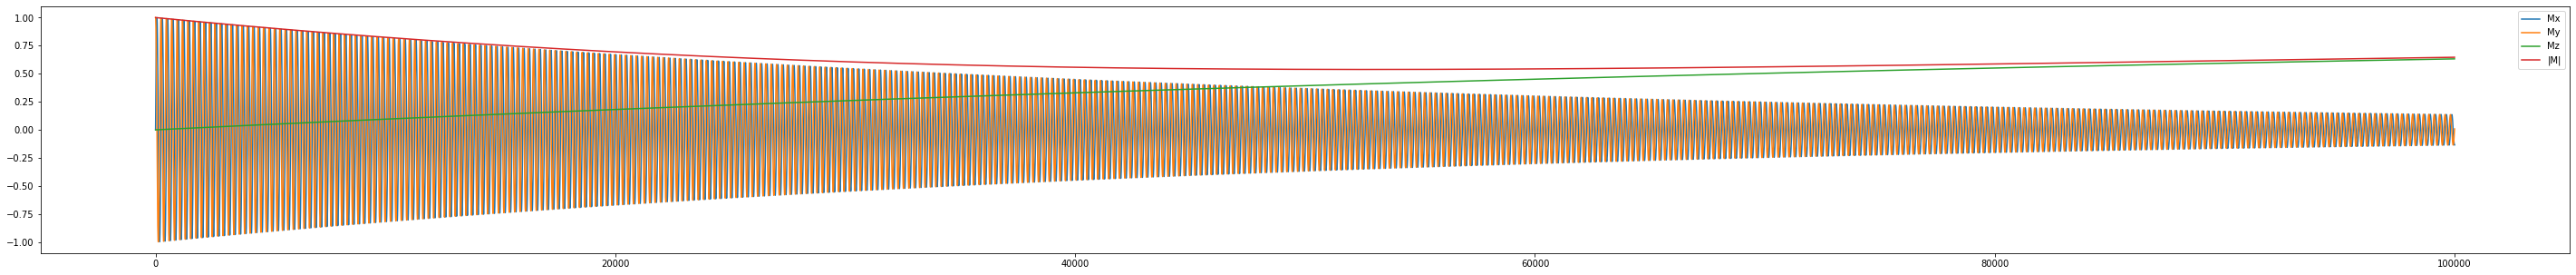

In [4]:

# Object settings
params = {
    'T1': 10e-3, # [s]
    'T2': 5e-3,  # [s] 
    'M0': 1      # [a.u.]
    }

# Simulation settings
M_init = np.array([0,1,0])
total_sim_time = 10e-3  # Total time in the virtual world [s]
time_step = 1e-7        # Time step size for discretization [s]

# Do simulation
M = solve_bloch_regime1(M_init, params, total_sim_time, time_step)

# Display
fig, ax = plt.subplots(1, 1, figsize=(50, 5))
ax.plot(M[:, 0], label='Mx')
ax.plot(M[:, 1], label='My')
ax.plot(M[:, 2], label='Mz')
ax.plot(np.linalg.norm(M, axis=1), label='|M|')
ax.legend()
plt.show()

## Regime 2: Applied Bx and/or By Fields

In [5]:
# Constants

B1_PEAK = 1e-3  # Peak value of RF magnetic field [T]

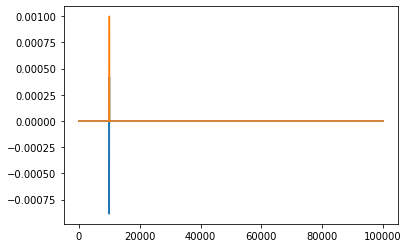

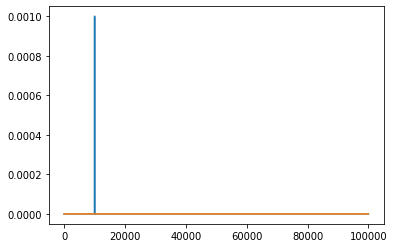

In [6]:
def solve_bloch_regime2(M_init, params, B1, total_sim_time, time_step, frame_of_ref):
    """
    Solving using Rodrigues' rotation formalism.
    """ 

    num_steps = int(total_sim_time / time_step)
    M = []
    M_n_prev = M_init
    
    for n in range(num_steps):

        # Step 1: Larmor term update
        if frame_of_ref == 'lab':
            B_eff_n = np.array([B1.real[n], B1.imag[n], B0])
        elif frame_of_ref == 'rotating':
            B_eff_n = np.array([B1.real[n], B1.imag[n], 0])
        
        if np.linalg.norm(B_eff_n) != 0:
            b_n = B_eff_n / np.linalg.norm(B_eff_n)
            theta_n = -2 * np.pi * GAMMA * np.linalg.norm(B_eff_n) * time_step
            M_n = np.cos(theta_n) * M_n_prev + \
                  (1 - np.cos(theta_n)) * np.dot(b_n, M_n_prev) * b_n + \
                  np.sin(theta_n) * np.cross(b_n, M_n_prev)
        else:
            M_n = M_n_prev
            
        # Step 2: Relaxation update
        M_n[0] = M_n[0] * (1 - time_step / params['T2'])
        M_n[1] = M_n[1] * (1 - time_step / params['T2'])
        M_n[2] = M_n[2] * (1 - time_step / params['T1']) + params['M0'] * (time_step / params['T1'])

        M.append(M_n)
        M_n_prev = M_n

    return np.array(M)


def rf_pulse_rect(total_sim_time, time_step, pulse_start_time, flip_angle, frame_of_ref):
    """
    Rectangular RF pulse.
    """
    
    num_steps = int(total_sim_time / time_step)
    n_vec = np.arange(0, num_steps)
    
    pulse_duration = flip_angle / (2 * np.pi * GAMMA * B1_PEAK)  # (s)
    pulse_mask = np.zeros_like(n_vec)
    pulse_mask[int(pulse_start_time / time_step) : int((pulse_start_time + pulse_duration) / time_step)] = 1
    
    phase = 0
    
    if frame_of_ref == 'lab':
        carrier_freq = GAMMA * B0
        B1 = B1_PEAK * np.exp(1j * phase - 1j * 2 * np.pi * carrier_freq * n_vec * time_step) * pulse_mask
    elif frame_of_ref == 'rotating':
        B1 = B1_PEAK * np.exp(1j * phase) * pulse_mask
        
    return B1


B1 = rf_pulse_rect(total_sim_time, time_step, 1e-3, np.pi/2, frame_of_ref='lab')
plt.plot(B1.real)
plt.plot(B1.imag)
plt.show()

B1 = rf_pulse_rect(total_sim_time, time_step, 1e-3, np.pi/2, frame_of_ref='rotating')
plt.plot(B1.real)
plt.plot(B1.imag)
plt.show()

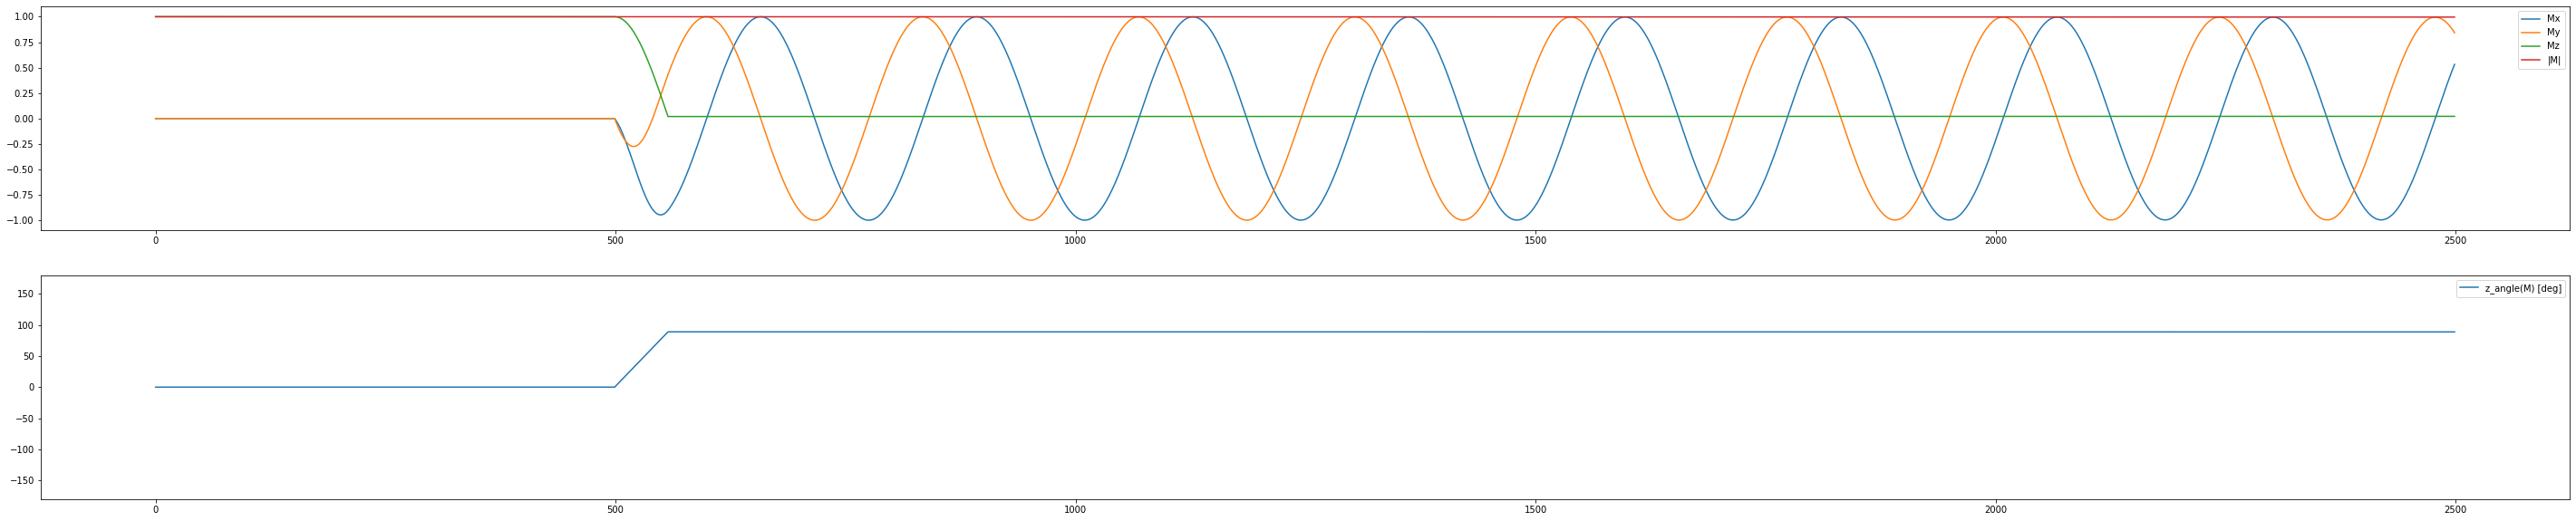

In [7]:

# Object settings
params = {
    'T1': 100e-3, # [s]
    'T2': 50e-3,  # [s] 
    'M0': 1       # [a.u.]
    }

# Simulation settings
M_init = np.array([0, 0, 1])
total_sim_time = 10e-3  # Total time in the virtual world [s]
time_step = 1e-7        # Time step size for discretization [s]
frame_of_ref = 'lab'

# RF settings
flip_angle = np.pi / 2    # [rad]
pulse_start_time = 1e-3   # [s]
B1 = rf_pulse_rect(total_sim_time, time_step, pulse_start_time, flip_angle, frame_of_ref)

# Do simulation
M = solve_bloch_regime2(M_init, params, B1, total_sim_time, time_step, frame_of_ref)

# Display
disp_range = [9500, 12000]
fig, axs = plt.subplots(2, 1, figsize=(50, 10))
axs[0].plot(M[:, 0][disp_range[0]:disp_range[1]], label='Mx')
axs[0].plot(M[:, 1][disp_range[0]:disp_range[1]], label='My')
axs[0].plot(M[:, 2][disp_range[0]:disp_range[1]], label='Mz')
axs[0].plot(np.linalg.norm(M, axis=1)[disp_range[0]:disp_range[1]], label='|M|')
axs[0].legend()

M_angles = np.degrees(np.arccos(np.dot(M, np.array([0,0,1]))))
axs[1].plot(M_angles[disp_range[0]:disp_range[1]], label='z_angle(M) [deg]')
axs[1].set_ylim((-180,180))
axs[1].legend()

plt.legend()
plt.show()
